Now we will use a PINN to solve the inverse problem

The differential equation we will be solving is:
$$
f' = R(1-t)*t
$$

but this time we don't know what R is. 

In [131]:
import numpy as np
from torch import nn
import torch
from torch.optim import Adam
import matplotlib.pyplot as plt
import itertools

In [132]:
# Data generation
def f_true(t,r,f):
    return f-r*t**3 / 3 + r*t**2/2

In [133]:
N = 10
R = 2
F0 = 1
t_data = torch.linspace(-1, 3, steps=N,requires_grad = True).view(-1, 1)
f_data = f_true(t_data.detach().numpy(), R, F0) 

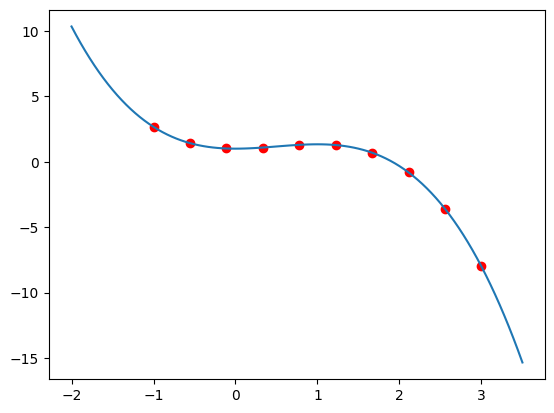

In [134]:
t_data_max = np.linspace(-2, 3.5,100)
plt.plot(t_data.detach().numpy(),f_data,'or')
plt.plot(t_data_max,f_true(t_data_max,R,F0))

In [135]:
class NNapproximator(nn.Module):
    def __init__(self,n_hidden,dim_hidden,act = nn.Tanh()):
        super().__init__()
        self.layer_in = nn.Linear(1,dim_hidden)
        self.layer_out = nn.Linear(dim_hidden,1)
        num_middle = n_hidden-1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden,dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
    def forward(self,x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        out = self.layer_out(out)
        return out

PINN = NNapproximator(2,2)

In [136]:
PINN(torch.tensor([[1.0],[1.0]]))

tensor([[0.6036],
        [0.6036]], grad_fn=<AddmmBackward0>)

In [137]:
r_second = nn.Parameter(torch.tensor([.5]))

In [138]:
# This is the forward function
def f(nn, x):
    return nn(x)

# This is the forward derivative function
def df(nn,x,order = 1):
    df_value = f(nn,x)
    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            grad_outputs = torch.ones_like(x),
            create_graph = True,
            retain_graph = True
        )[0]
    return df_value

In [139]:
F0 = 1.0 # Boundary condition

In [140]:
def compute_loss(nn,r,x):
    de_loss = df(nn,x) - r*x*(1-x)
    bc_loss = f(nn,t_data) - torch.as_tensor(f_data)
    final_loss = de_loss.pow(2).mean() + bc_loss.pow(2).mean()
    return final_loss

In [141]:
def optimise(optimiser,nn,r,x):
    optimiser.zero_grad()
    loss = compute_loss(nn,r,x)
    loss.backward()
    optimiser.step()
    return loss

In [142]:
lr = 0.001
epochs = 30000
PINN = NNapproximator(2,10)
R_approx = Rapproximator()
#learnable_params = list(PINN.parameters()) + list(R_approx.parameters())
learnable_params = itertools.chain(PINN.parameters(), (r_second,))
pi_optimizer = Adam(learnable_params, lr=lr)

In [143]:
loss_vector = []
iteration_vector =[]
for i in range(epochs):
    #loss = optimise(pi_optimizer,PINN,R_approx,t_data)
    loss = optimise(pi_optimizer,PINN,r_second,t_data)
    if i % 1000==0:
        iteration_vector.append(i)
        loss_vector.append(loss.detach().numpy())
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000


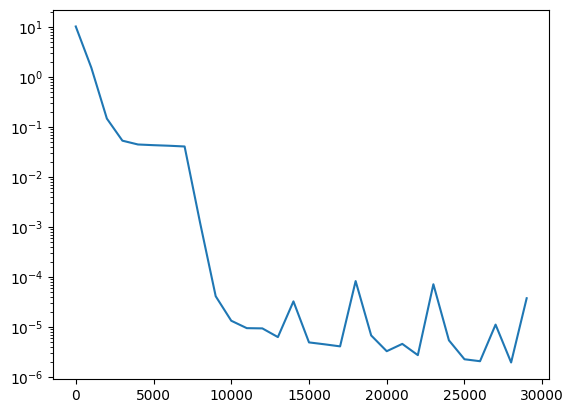

In [125]:
plt.plot(iteration_vector,loss_vector)
plt.yscale('log')

In [126]:
t_data_domain = torch.linspace(-2, 3.5, steps=1000).view(-1, 1)
with torch.no_grad():
    f_prediction = PINN(t_data_domain).numpy()

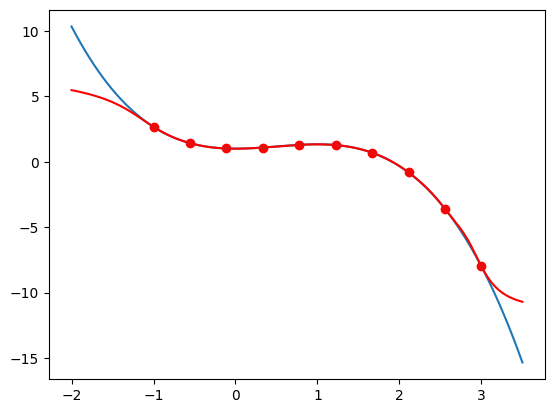

In [127]:
t_data_max = np.linspace(-2, 3.5,100)
plt.plot(t_data.detach().numpy(),f_data,'or')
plt.plot(t_data_max,f_true(t_data_max,R,F0))
plt.plot(t_data_domain,f_prediction,'r')

In [128]:
[t for t in PINN.parameters()]

[Parameter containing:
 tensor([[ 0.6156],
         [ 0.5090],
         [-0.7465],
         [-0.7662],
         [ 0.6809],
         [ 1.6559],
         [-0.4952],
         [ 0.3843],
         [-0.7149],
         [-1.1235]], requires_grad=True),
 Parameter containing:
 tensor([-1.7526, -1.1646,  2.1029,  2.0748, -0.6290,  1.1384,  1.5429, -0.9125,
         -1.0154,  2.6493], requires_grad=True),
 Parameter containing:
 tensor([[-1.0494,  0.8047, -1.0299,  0.8790, -1.6937,  1.0389, -1.2769, -1.0195,
           1.3346,  0.4824]], requires_grad=True),
 Parameter containing:
 tensor([-0.7994], requires_grad=True),
 Parameter containing:
 tensor([[-2.2218e-01, -2.6962e-01, -2.8803e-01, -1.4408e-02,  6.1693e-02,
           1.1758e+00,  1.2368e-02, -3.0203e-01, -3.2549e-01,  1.5669e-01],
         [-5.5303e-01, -4.2452e-01,  6.5546e-01,  8.3354e-01, -4.3101e-01,
           3.0628e-01,  2.0073e-01, -3.8012e-01, -4.2406e-01,  9.0531e-01],
         [ 1.2560e+00,  1.2920e+00, -1.1691e+00, -1.3783e+

In [130]:
[t for t in r_second]

[tensor(1.9915, grad_fn=<UnbindBackward0>)]